### Libarires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras import optimizers
from keras.callbacks import EarlyStopping
df=pd.read_csv('C:\\Users\\Hp\\Desktop\\Codes\\New1\\Original.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (86928, 5)


,Date,Time,Temp,Humidity,Active_Power
0,1/31/2006,1:00:00 AM,11.6000,98,732.8000
1,1/31/2006,2:00:00 AM,11.6000,98,711.1000
2,1/31/2006,3:00:00 AM,21.8800,91,706.5000
3,1/31/2006,4:00:00 AM,24.4100,79,711.7000
4,1/31/2006,5:00:00 AM,25.6800,75,824.6000


### Data Prepration

In [2]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Active_Power'] = pd.to_numeric(df['Active_Power'], errors='coerce')
df = df.dropna(subset=['Active_Power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Active_Power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (86928, 7)
The time series starts from:  2006-01-31 00:00:00
The time series ends on:  2015-12-31 23:00:00


In [3]:
df

,date_time,Active_Power,year,quarter,month,day,weekday
0,2006-01-31 00:00:00,789.7000,2006,1,1,31,1
1,2006-01-31 01:00:00,732.8000,2006,1,1,31,1
2,2006-01-31 02:00:00,711.1000,2006,1,1,31,1
3,2006-01-31 03:00:00,706.5000,2006,1,1,31,1
4,2006-01-31 04:00:00,711.7000,2006,1,1,31,1
...,...,...,...,...,...,...,...
86923,2015-12-31 19:00:00,2198.2000,2015,4,12,31,1
86924,2015-12-31 20:00:00,2082.7000,2015,4,12,31,1
86925,2015-12-31 21:00:00,1823.6000,2015,4,12,31,1
86926,2015-12-31 22:00:00,1614.3000,2015,4,12,31,1


### Data Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86928 entries, 0 to 86927
Data columns (total 7 columns):
date_time       86928 non-null datetime64[ns]
Active_Power    86928 non-null float64
year            86928 non-null int64
quarter         86928 non-null int64
month           86928 non-null int64
day             86928 non-null int64
weekday         86928 non-null int32
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4)
memory usage: 4.3 MB


### Data Vizulization

Kurtosis of normal distribution: -0.5080127300691748
Skewness of normal distribution: 0.34342776775097317


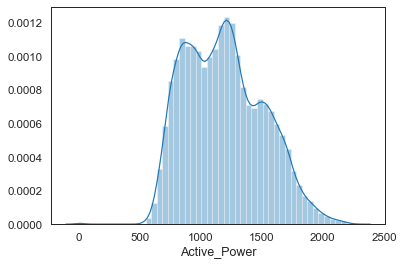

In [5]:
sns.distplot(df.Active_Power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Active_Power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Active_Power)))

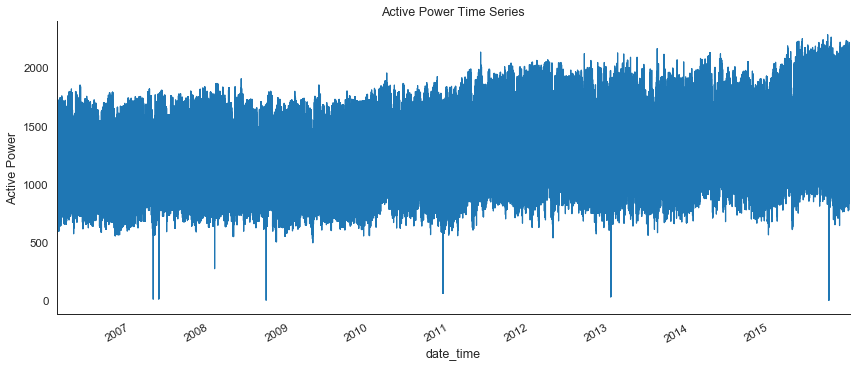

In [6]:
df1=df.loc[:,['date_time','Active_Power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Active Power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Active Power Time Series')
sns.despine(top=True)
plt.show();

### Boxplot

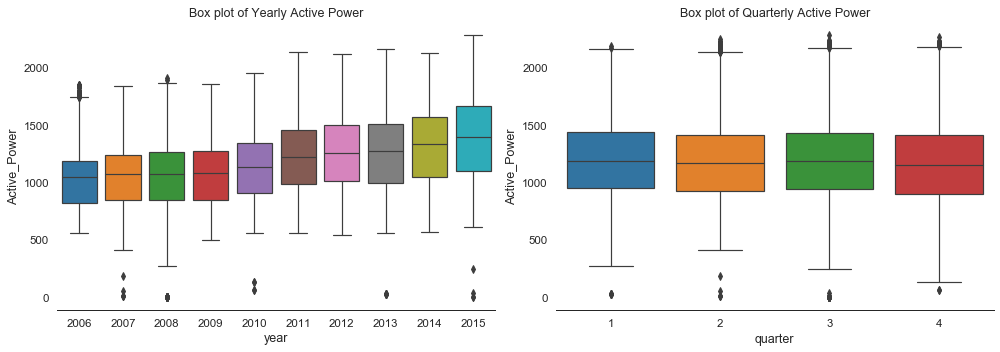

In [7]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Active_Power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Active Power')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Active_Power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Active Power')
sns.despine(left=True)
plt.tight_layout();

### Active Power Distribuiton of Data

,count,mean,std,min,25%,50%,75%,max
Active_Power,86928.0000,1190.8515,319.8326,0.0000,928.4000,1172.1000,1421.3000,2283.4000


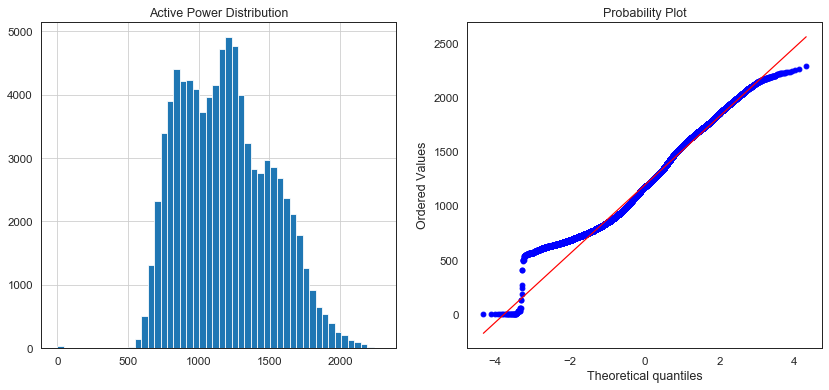

In [8]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Active_Power'].hist(bins=50)
plt.title('Active Power Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Active_Power'], plot=plt);
df1.describe().T

# Seasonal Analysis

Text(0.5, 1.0, 'April Month Demand Pattern')

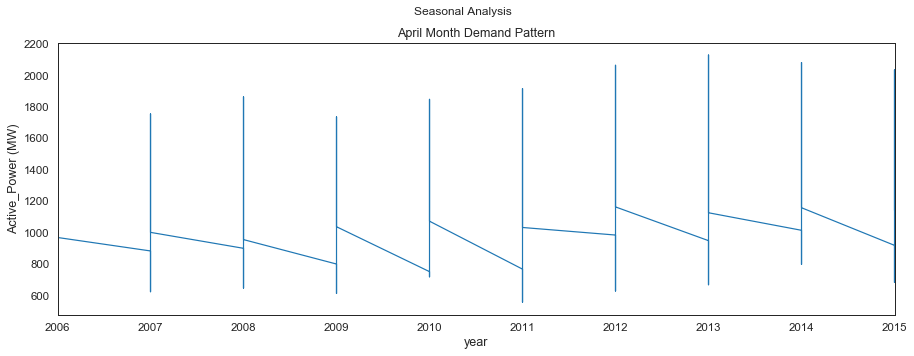

In [9]:
seasonalAnalysis = df.set_index('year')

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Seasonal Analysis')
plt.xlabel('Year')
plt.ylabel('Active_Power (MW)')
seasonalAnalysis.loc[seasonalAnalysis["month"]==2, 'Active_Power'].plot().set_title("April Month Demand Pattern")


Text(0.5, 1.0, 'December')

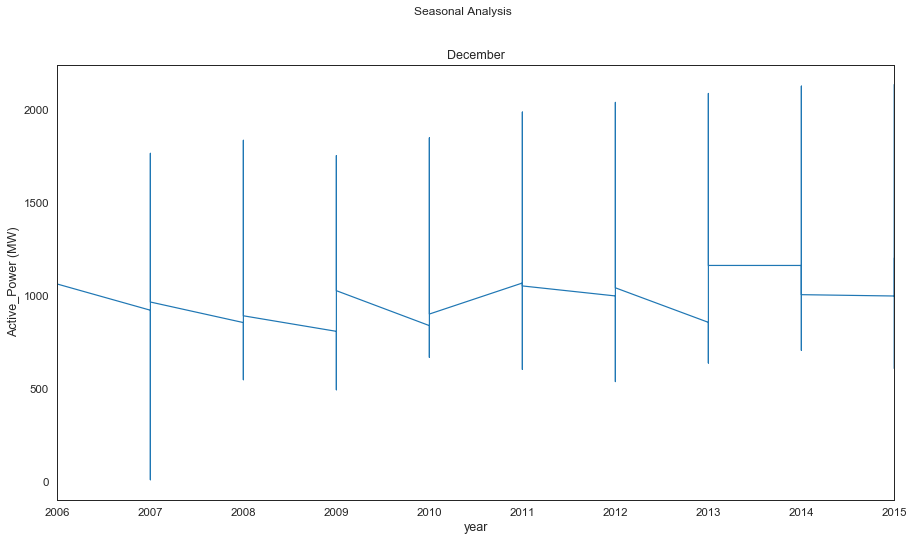

In [10]:
seasonalAnalysis = df.set_index('year')

fig = plt.figure(figsize=(15, 8))
fig.suptitle('Seasonal Analysis')
plt.xlabel('Year')
plt.ylabel('Active_Power (MW)')
seasonalAnalysis.loc[seasonalAnalysis["month"]==4, 'Active_Power'].plot().set_title("December")

Text(0.5, 1.0, 'December')

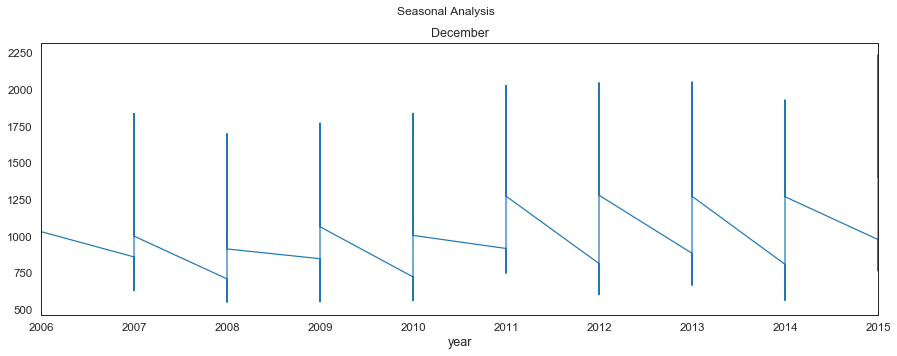

In [11]:
seasonalAnalysis = df.set_index('year')

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Seasonal Analysis')

seasonalAnalysis.loc[seasonalAnalysis["month"]==12, 'Active_Power'].plot().set_title("December")

In [12]:
fig = plt.figure(figsize=(15,20))


<Figure size 1080x1440 with 0 Axes>

### Resampled Active Power Data

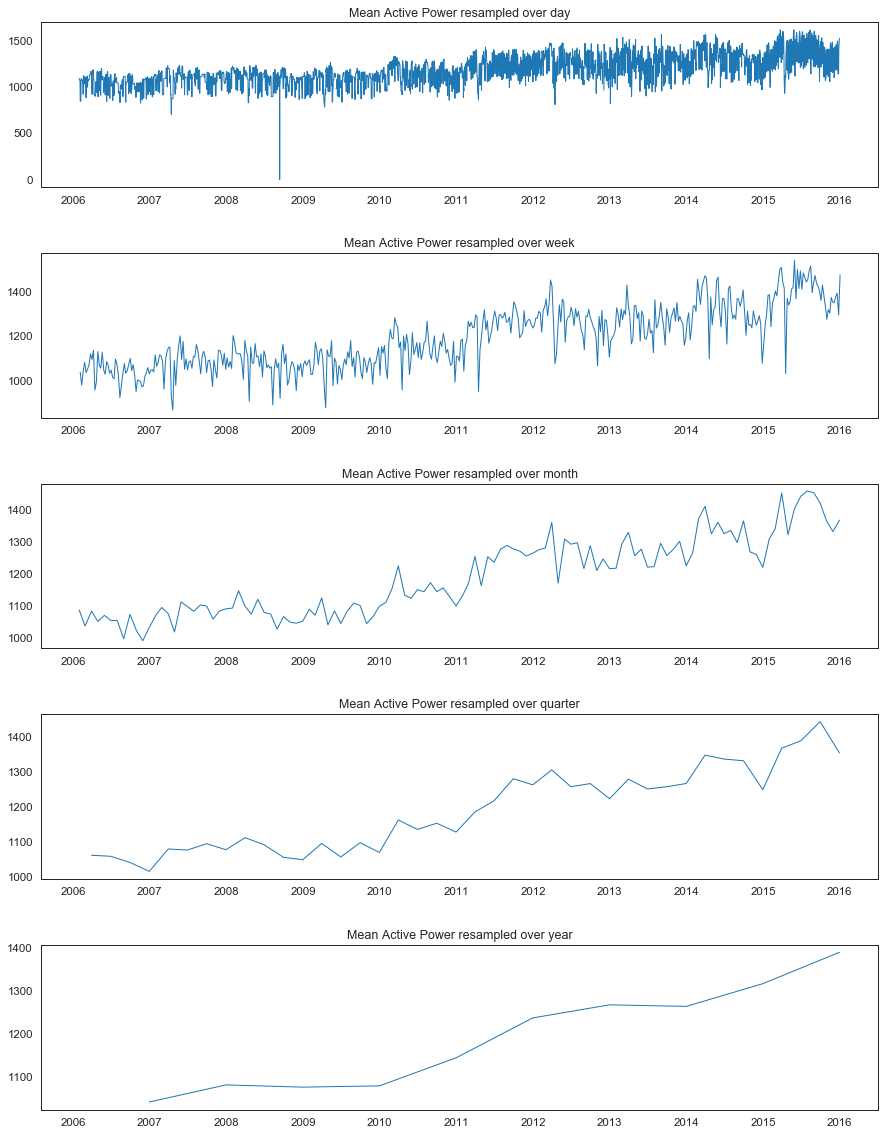

In [13]:
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Active_Power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Active Power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Active_Power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Active Power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Active_Power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Active Power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Active_Power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Active Power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Active_Power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Active Power resampled over year')
ax5.tick_params(axis='both', which='major');

## Model

Model Used:

* CNN (Convolution Neural Network)
* Simple RNN (Simple Recurruent Nueral Network)
* LSTM (Long short-term memory Recurrent Nueral Network)

### For each Model
* Regulizaer = "Relu"
* Adam Optimzier(Learning Rate) = 0.01

### Train and Test Data

In [14]:
df1=df.drop(['year','quarter','month','day','weekday'],axis=1) 
df1

,date_time,Active_Power
0,2006-01-31 00:00:00,789.7000
1,2006-01-31 01:00:00,732.8000
2,2006-01-31 02:00:00,711.1000
3,2006-01-31 03:00:00,706.5000
4,2006-01-31 04:00:00,711.7000
...,...,...
86923,2015-12-31 19:00:00,2198.2000
86924,2015-12-31 20:00:00,2082.7000
86925,2015-12-31 21:00:00,1823.6000
86926,2015-12-31 22:00:00,1614.3000


In [15]:
df1 = df1.set_index("date_time")
df1.head()

,Active_Power
date_time,
2006-01-31 00:00:00,789.7000
2006-01-31 01:00:00,732.8000
2006-01-31 02:00:00,711.1000
2006-01-31 03:00:00,706.5000
2006-01-31 04:00:00,711.7000


In [16]:
df
x=df.drop(['Active_Power'],axis=1) 
y = df['Active_Power']

### Split dataset

In [163]:
train_data = df1[:len(df)-17389]
test_data = df1[len(df)-17389:]


norm = np.linalg.norm(train_data , ord=2, axis=0, keepdims=True)
train_data = train_data/norm

norm = np.linalg.norm(test_data, ord=2, axis=0, keepdims=True)
test_data = test_data/norm



test_data.head()

,Active_Power
date_time,
2014-01-06 14:00:00,0.0080
2014-01-06 15:00:00,0.0081
2014-01-06 16:00:00,0.0081
2014-01-06 17:00:00,0.0080
2014-01-06 18:00:00,0.0083


In [164]:
train_data.head(5)


,Active_Power
date_time,
2006-01-31 00:00:00,0.0025
2006-01-31 01:00:00,0.0023
2006-01-31 02:00:00,0.0023
2006-01-31 03:00:00,0.0023
2006-01-31 04:00:00,0.0023


In [165]:
len(test_data),len(train_data)

(17386, 69542)

### Min Max Scaler of Data 

In [166]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [167]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [168]:
scaler.fit(test_data)
scaled_test_data = scaler.transform(test_data)

### The Keras deep learning library provides the TimeseriesGenerator to automatically transform both univariate and multivariate time series data into samples, ready to train deep learning models.

In [169]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=5)

### Convolution Neural Network

In [170]:
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_input, n_features)))
CNN.add(MaxPooling1D(pool_size=2,strides=2))
CNN.add(Dropout(0.1))
CNN.add(Flatten())
CNN.add(Dense(50, activation='relu'))
CNN.add(Dense(32, activation='relu'))
CNN.add(Dense(2, activation='relu'))
CNN.add(Dense(1, activation='relu'))

Model Summary

In [171]:
CNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 8, 64)             384       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_29 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_30 (Dense)             (None, 2)                

### monitor validation progress


In [172]:
early = EarlyStopping(mode = "min", patience = 3)
callbacks_list = [early]
    
CNN.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])
from keras.callbacks import ModelCheckpoint
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.young.hdf5', 
                               verbose=1, save_best_only=True)

### Run Model

In [173]:
history = CNN.fit_generator(generator
                      , steps_per_epoch= len(generator)/10
                      , epochs= 25
                      , callbacks=[checkpointer]
                      , verbose=1)

Epoch 1/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0124 - mse: 0.0124
Epoch 2/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0056 - mse: 0.0056
Epoch 3/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0040 - mse: 0.0040
Epoch 4/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0036 - mse: 0.0036
Epoch 5/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0032 - mse: 0.0032
Epoch 6/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0028 - mse: 0.0028
Epoch 7/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0028 - mse: 0.0028
Epoch 8/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0025 - mse: 0.0025
Epoch 9/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0021 - mse: 0.0021
Epoch 10/25
1391/1390 [==============================] - 2s 1ms/step - loss: 0.0021 - mse: 0.0021
Epoch 11/25
1391/1390 [======

### Plot Loss

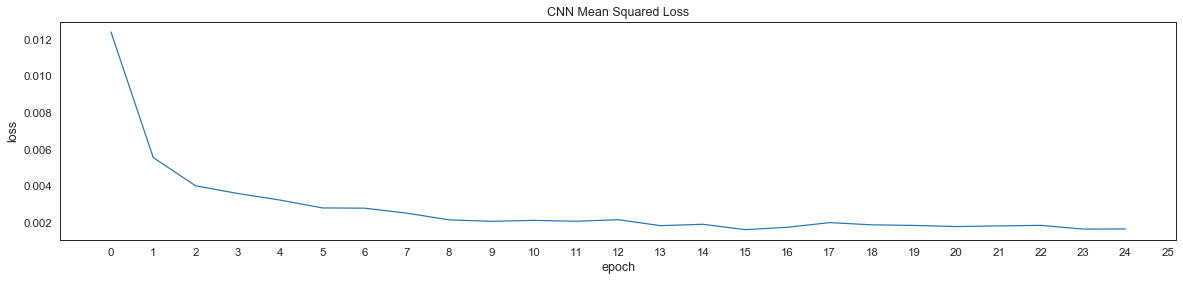

In [174]:
losses_CNN = history.history['loss']
plt.figure(figsize=(20,4))
plt.xticks(np.arange(0,71,1))
plt.title('CNN Mean Squared Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(len(losses_CNN)),losses_CNN);

### Prediction 

In [175]:
CNN_predictions_scaled = list()

batch = scaled_test_data[-12:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    CNN_pred = CNN.predict(current_batch)[0]
    CNN_predictions_scaled.append(CNN_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[CNN_pred]],axis=1)

### Transform Values(Scale the Value Back to its Orginal Form)

In [176]:
CNN_predictions = scaler.inverse_transform(CNN_predictions_scaled)

### Store the data and Visualization

In [177]:
test_data['CNN_Predictions'] = CNN_predictions
test_data
true_pred = test_data['Active_Power']
test_data['CNN_Predictions']

date_time
2014-01-06 14:00:00   0.0057
2014-01-06 15:00:00   0.0052
2014-01-06 16:00:00   0.0048
2014-01-06 17:00:00   0.0046
2014-01-06 18:00:00   0.0046
                       ...  
2015-12-31 19:00:00   0.0060
2015-12-31 20:00:00   0.0061
2015-12-31 21:00:00   0.0065
2015-12-31 22:00:00   0.0070
2015-12-31 23:00:00   0.0074
Name: CNN_Predictions, Length: 17386, dtype: float64

In [178]:
from sklearn.metrics import accuracy_score
mae = metrics.mean_absolute_error(true_pred,CNN_predictions)
mse = metrics.mean_squared_error(true_pred, CNN_predictions)
rmse = np.sqrt(metrics.mean_squared_error(true_pred, CNN_predictions))
r2_square = metrics.r2_score(true_pred, CNN_predictions)
metrices = {
    'model' : "CNN",
    'mae' : mae,
    'rmse' : rmse,
    'r2_square' : r2_square
}

#df = pd.DataFrame (metrices, columns = ['Model','mae','rmse','r2_square'])
CNNmetric = ["CNN",mae,mse,rmse,r2_square]
df = pd.DataFrame([CNNmetric],columns= ['Model','mae','mse','rmse','r2_square'])

print('Total Mean Absolute Error:', mae)
print('Total Mean Squared Error:', mse)
print('Total Root Mean Squared Error:', rmse)
print('Total R2 Square', r2_square)
df

Total Mean Absolute Error: 0.002017884227249875
Total Mean Squared Error: 6.2191928864058824e-06
Total Root Mean Squared Error: 0.0024938309658847934
Total R2 Square -0.8918685229851837


,Model,mae,mse,rmse,r2_square
0,CNN,0.0020,0.0000,0.0025,-0.8919


### Visualising the results


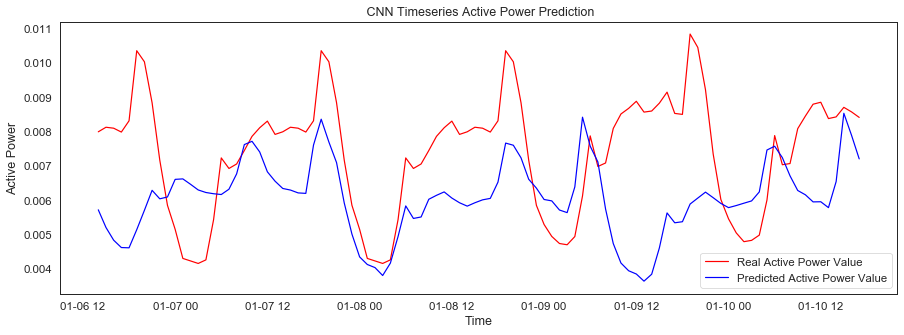

In [179]:
plt.figure(figsize=(15,5))
plt.plot(test_data.Active_Power[0:100], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['CNN_Predictions'][0:100], color = 'blue', label = 'Predicted Active Power Value')
plt.title(' CNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

In [180]:
mae = mean_absolute_error(test_data.Active_Power,CNN_predictions_scaled)
mse = mean_squared_error(test_data.Active_Power, CNN_predictions_scaled)
rmse = np.sqrt(mean_squared_error(test_data.Active_Power, CNN_predictions_scaled))
r2_square = metrics.r2_score(test_data.Active_Power, CNN_predictions_scaled)
print('Total Mean Absolute Error:', mae)
print('Total Mean Squared Error:', mse)
print('Total Root Mean Squared Error:', rmse)
print('Total R2 Square', r2_square)

Total Mean Absolute Error: 0.4795304363709913
Total Mean Squared Error: 0.23815435068652308
Total Root Mean Squared Error: 0.48801060509636784
Total R2 Square -72445.17234185639


In [181]:
len(test_data.CNN_Predictions)

17386

### Visualization for 10 points

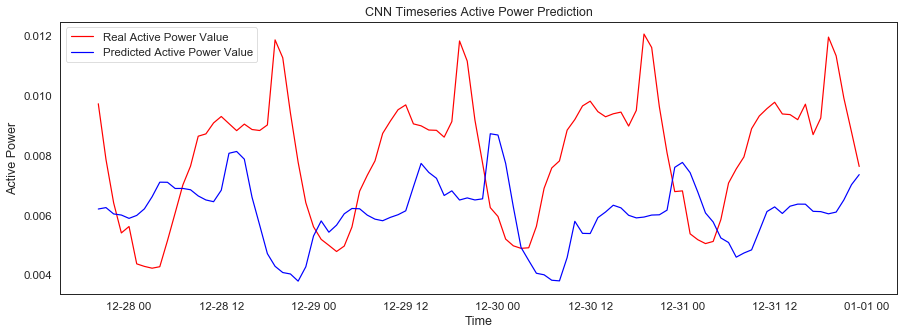

In [183]:
plt.figure(figsize=(15,5))
plt.plot(test_data.Active_Power[-100:], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data.CNN_Predictions[-100:], color = 'blue', label = 'Predicted Active Power Value')
plt.title('CNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

## Visualization for 500 points

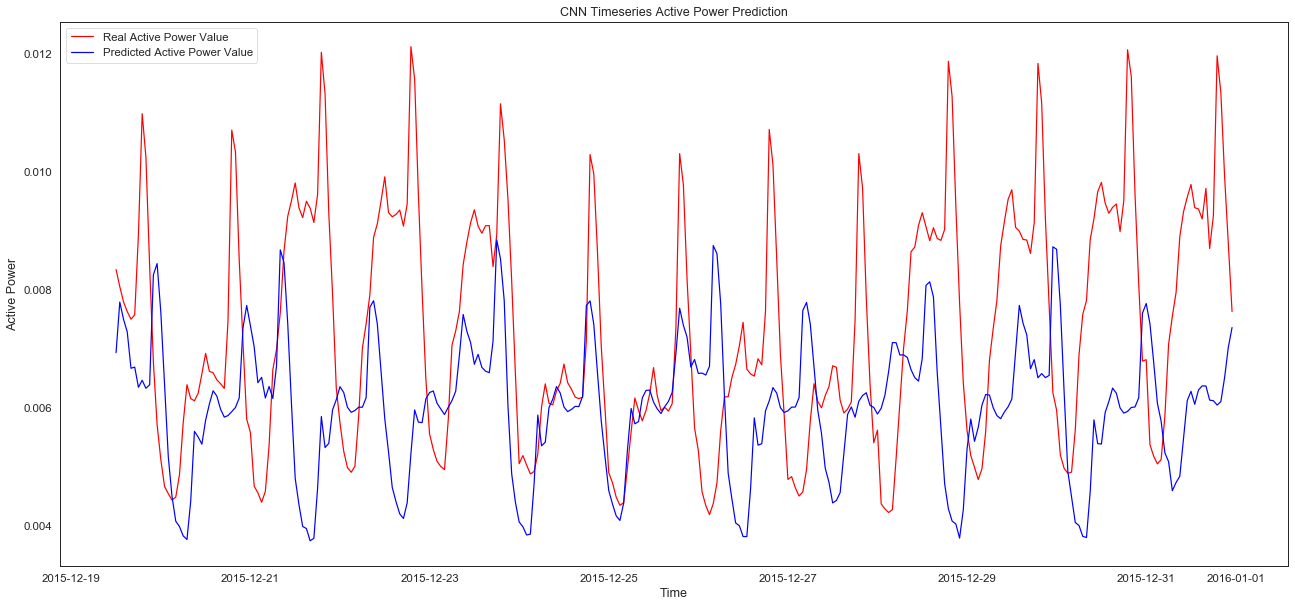

In [184]:
plt.figure(figsize=(22,10))
plt.plot(test_data.Active_Power[-300:], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data.CNN_Predictions[-300:], color = 'blue', label = 'Predicted Active Power Value')
plt.title('CNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

### Simple RNN 

In [185]:
RNN = Sequential()
RNN.add(SimpleRNN(100, input_shape = (n_input, n_features), activation = 'relu'))
RNN.add(Dropout(0.15))
RNN.add(Dense(50, activation = 'relu'))
RNN.add(Dropout(0.1))
RNN.add(Dense(50, activation = 'relu'))
RNN.add(Dropout(0.1))
RNN.add(Dense(1, activation='relu'))

### Summary

In [186]:
RNN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)               

In [187]:
early = EarlyStopping(mode = "min", patience = 3)
callbacks_list = [early]
    
RNN.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.RNN.hdf5', 
                               verbose=1, save_best_only=True)

### Run Model

In [188]:
history = RNN.fit_generator(generator
                      , steps_per_epoch= len(generator)/10
                      , epochs= 15
                      , callbacks=[checkpointer]
                      , verbose=1)

Epoch 1/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0100 - mse: 0.0100
Epoch 2/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 3/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0035 - mse: 0.0035
Epoch 4/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0030 - mse: 0.0030
Epoch 5/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0028 - mse: 0.0028
Epoch 6/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0028 - mse: 0.0028
Epoch 7/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0025 - mse: 0.0025
Epoch 8/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0024 - mse: 0.0024
Epoch 9/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0021 - mse: 0.0021
Epoch 10/15
1391/1390 [==============================] - 4s 3ms/step - loss: 0.0022 - mse: 0.0022
Epoch 11/15
1391/1390 [======

### Plot

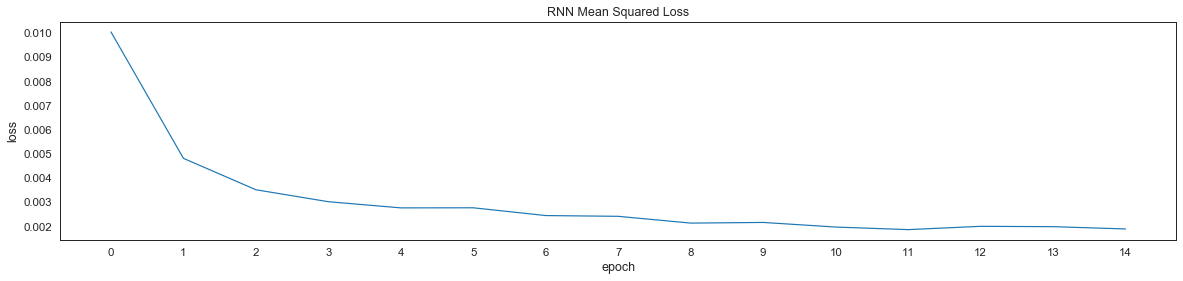

In [189]:
losses_RNN = RNN.history.history['loss']
plt.figure(figsize=(20,4))
plt.xticks(np.arange(0,71,1))
plt.title('RNN Mean Squared Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(len(losses_RNN)),losses_RNN);

### Prediction

In [190]:
RNN_predictions_scaled = list()

batch = scaled_test_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    RNN_pred = RNN.predict(current_batch)[0]
    RNN_predictions_scaled.append(RNN_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[RNN_pred]],axis=1)

In [191]:
RNN_predictions = scaler.inverse_transform(RNN_predictions_scaled)

In [192]:
test_data['RNN_Predictions'] = RNN_predictions
test_data
true_pred = test_data['Active_Power']
test_data

,Active_Power,CNN_Predictions,RNN_Predictions
date_time,,,
2014-01-06 14:00:00,0.0080,0.0057,0.0068
2014-01-06 15:00:00,0.0081,0.0052,0.0060
2014-01-06 16:00:00,0.0081,0.0048,0.0056
2014-01-06 17:00:00,0.0080,0.0046,0.0054
2014-01-06 18:00:00,0.0083,0.0046,0.0054
...,...,...,...
2015-12-31 19:00:00,0.0120,0.0060,0.0088
2015-12-31 20:00:00,0.0113,0.0061,0.0088
2015-12-31 21:00:00,0.0099,0.0065,0.0088


In [193]:
from sklearn.metrics import accuracy_score
maernn = metrics.mean_absolute_error(true_pred,RNN_predictions_scaled)
msernn = metrics.mean_squared_error(true_pred, RNN_predictions_scaled)
rmsernn = np.sqrt(metrics.mean_squared_error(true_pred, RNN_predictions_scaled))
r2_squarernn = metrics.r2_score(true_pred, RNN_predictions)
rnnmetic = ["RNN",maernn,msernn,rmsernn,r2_squarernn]
data = [CNNmetric,rnnmetic]
df = pd.DataFrame(data,columns= ['Model','mae','mse','rmse','r2_square'])

print('Total Mean Absolute Error:', maernn)
print('Total Mean Squared Error:', msernn)
print('Total Root Mean Squared Error:', rmsernn)
print('Total R2 Square', r2_squarernn)
df

Total Mean Absolute Error: 0.7009602286636911
Total Mean Squared Error: 0.4913800139024493
Total Root Mean Squared Error: 0.7009850311543387
Total R2 Square -0.6306140919478869


,Model,mae,mse,rmse,r2_square
0,CNN,0.0020,0.0000,0.0025,-0.8919
1,RNN,0.7010,0.4914,0.7010,-0.6306


### Vizulization of Result

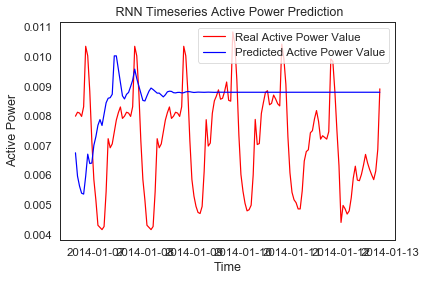

In [198]:
plt.plot(test_data.Active_Power[0:150], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['RNN_Predictions'][0:150], color = 'blue', label = 'Predicted Active Power Value')
plt.title(' RNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

## Visualization for 10 points

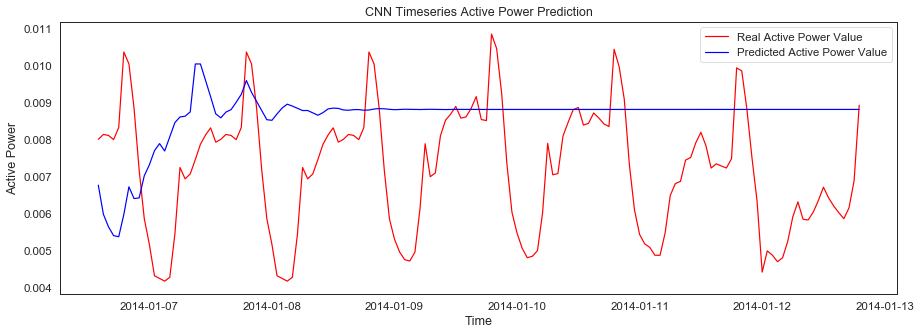

In [199]:
plt.figure(figsize=(15,5))
plt.plot(test_data.Active_Power[0:150], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['RNN_Predictions'][0:150], color = 'blue', label = 'Predicted Active Power Value')
plt.title('CNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

## Visualization for 100 points

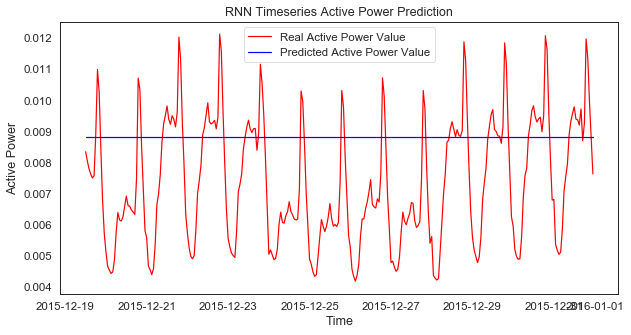

In [200]:
plt.figure(figsize=(10,5))
plt.plot(test_data.Active_Power[-300:], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['RNN_Predictions'][-300:], color = 'blue', label = 'Predicted Active Power Value')
plt.title('RNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

### LSTM

Two Model Run which u prefer

Better but take more time to run

model = Sequential()

model.add(LSTM(units = 100,return_sequences = True,input_shape = (n_input, n_features)))
model.add(Dropout(0.25))

model.add(LSTM(units = 100,return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1))

In [201]:
model = Sequential()
model.add(LSTM(60, input_shape=(n_input, n_features), activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summary

In [202]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dropout_17 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [203]:
early = EarlyStopping(mode = "min", patience = 7)
callbacks_list = [early]
    
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.RNN.hdf5', 
                               verbose=1, save_best_only=True)

### Run Model

In [204]:
history = model.fit_generator(generator
                      , steps_per_epoch= len(generator)/10
                      , epochs= 15
                      , callbacks=[checkpointer]
                      , verbose=1)

Epoch 1/15
1391/1390 [==============================] - 7s 5ms/step - loss: 0.0213 - mse: 0.0213
Epoch 2/15
1391/1390 [==============================] - 6s 4ms/step - loss: 0.0104 - mse: 0.0104
Epoch 3/15
1391/1390 [==============================] - 6s 4ms/step - loss: 0.0077 - mse: 0.0077
Epoch 4/15
1391/1390 [==============================] - 7s 5ms/step - loss: 0.0066 - mse: 0.0066
Epoch 5/15
1391/1390 [==============================] - 6s 4ms/step - loss: 0.0057 - mse: 0.0057
Epoch 6/15
1391/1390 [==============================] - 6s 4ms/step - loss: 0.0049 - mse: 0.0049
Epoch 7/15
1391/1390 [==============================] - 6s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 8/15
1391/1390 [==============================] - 5s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 9/15
1391/1390 [==============================] - 6s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 10/15
1391/1390 [==============================] - 5s 4ms/step - loss: 0.0034 - mse: 0.0034
Epoch 11/15
1391/1390 [======

### Plot

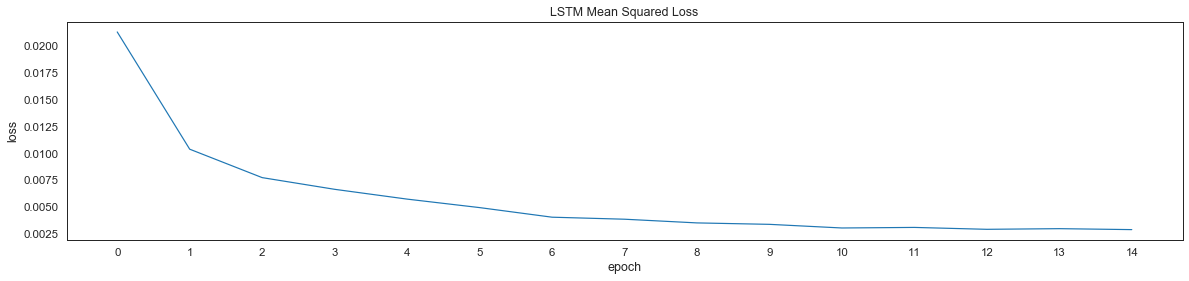

In [205]:
losses_LSTM = model.history.history['loss']
plt.figure(figsize=(20,4))
plt.xticks(np.arange(0,71,1))
plt.title('LSTM Mean Squared Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(len(losses_LSTM)),losses_LSTM);

### Prediction


In [206]:
LSTM_predictions_scaled = list()

batch = scaled_test_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    LSTM_pred = model.predict(current_batch)[0]
    LSTM_predictions_scaled.append(LSTM_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[LSTM_pred]],axis=1)

In [158]:
LSTM_predictions = scaler.inverse_transform(LSTM_predictions_scaled)
LSTM_predictions_scaled

[array([0.7045727], dtype=float32),
 array([0.7006154], dtype=float32),
 array([0.6993746], dtype=float32),
 array([0.70467484], dtype=float32),
 array([0.7163265], dtype=float32),
 array([0.7249114], dtype=float32),
 array([0.7821804], dtype=float32),
 array([0.80652153], dtype=float32),
 array([0.76540524], dtype=float32),
 array([0.70392466], dtype=float32),
 array([0.67425627], dtype=float32),
 array([0.68559706], dtype=float32),
 array([0.70844686], dtype=float32),
 array([0.7159017], dtype=float32),
 array([0.7079642], dtype=float32),
 array([0.7535856], dtype=float32),
 array([0.7825624], dtype=float32),
 array([0.7394521], dtype=float32),
 array([0.7143135], dtype=float32),
 array([0.7037045], dtype=float32),
 array([0.7083215], dtype=float32),
 array([0.7091194], dtype=float32),
 array([0.7194495], dtype=float32),
 array([0.7256126], dtype=float32),
 array([0.72176075], dtype=float32),
 array([0.72563076], dtype=float32),
 array([0.7088571], dtype=float32),
 array([0.7049933],

In [159]:
test_data['LSTM_predictions'] = LSTM_predictions
test_data
true_pred = test_data['Active_Power']

In [160]:
from sklearn.metrics import accuracy_score
maelstm = metrics.mean_absolute_error(true_pred,LSTM_predictions_scaled)
mselstm = metrics.mean_squared_error(true_pred, LSTM_predictions_scaled)
rmselstm = np.sqrt(metrics.mean_squared_error(true_pred, LSTM_predictions_scaled))
r2_squarelstm = metrics.r2_score(true_pred, LSTM_predictions)

lstmMetric = ["LSTM",maelstm,mselstm,rmselstm,r2_squarelstm]
data = [CNNmetric,rnnmetic,lstmMetric]
df = pd.DataFrame(data,columns= ['Model','mae','mse','rmse','r2_square'])

print('Total Mean Absolute Error:', maelstm)
print('Total Mean Squared Error:', mselstm)
print('Total Root Mean Squared Error:', rmselstm)
print('Total R2 Square', r2_squarelstm)
df

Total Mean Absolute Error: 0.6732831076004185
Total Mean Squared Error: 0.45333700394118853
Total Root Mean Squared Error: 0.6733030550511326
Total R2 Square -0.5266217438318945


,Model,mae,mse,rmse,r2_square
0,CNN,0.0028,0.0000,0.0032,-1.7674
1,RNN,0.7185,0.5426,0.7366,-2.2256
2,LSTM,0.6733,0.4533,0.6733,-0.5266


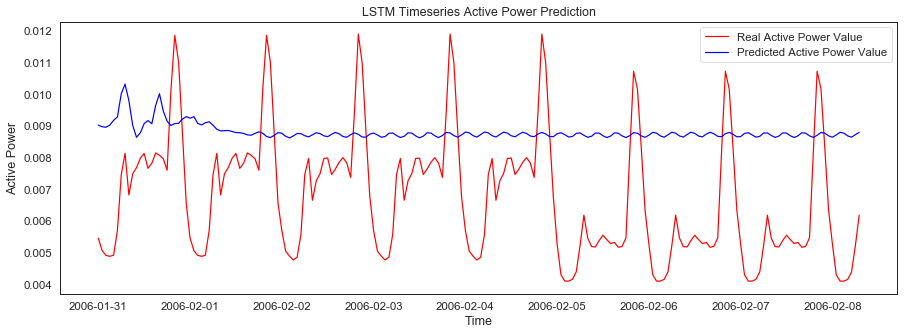

In [161]:
plt.figure(figsize=(15,5))
plt.plot(test_data.Active_Power[0:200], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['LSTM_predictions'][0:200], color = 'blue', label = 'Predicted Active Power Value')
plt.title('LSTM Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

## Visualization for 10 points

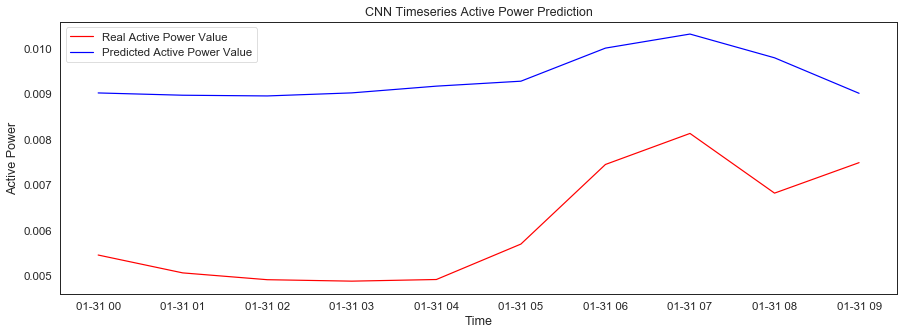

In [162]:
plt.figure(figsize=(15,5))
plt.plot(test_data.Active_Power[0:10], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['LSTM_predictions'][0:10], color = 'blue', label = 'Predicted Active Power Value')
plt.title('CNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

## Visualization for 100 points

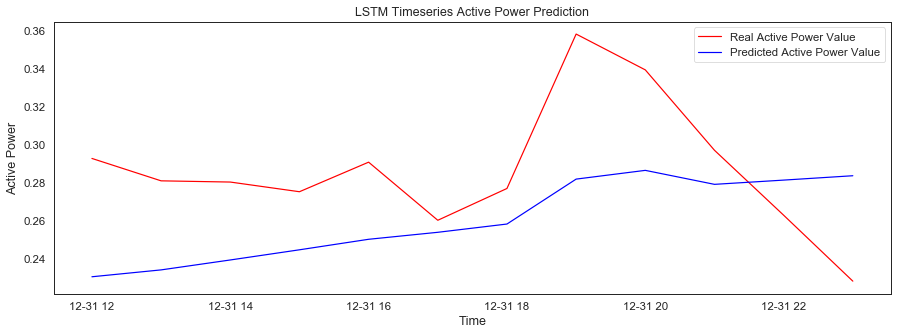

In [63]:
plt.figure(figsize=(15,5))
plt.plot(test_data.Active_Power[0:500], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['LSTM_predictions'][0:500], color = 'blue', label = 'Predicted Active Power Value')
plt.title('LSTM Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

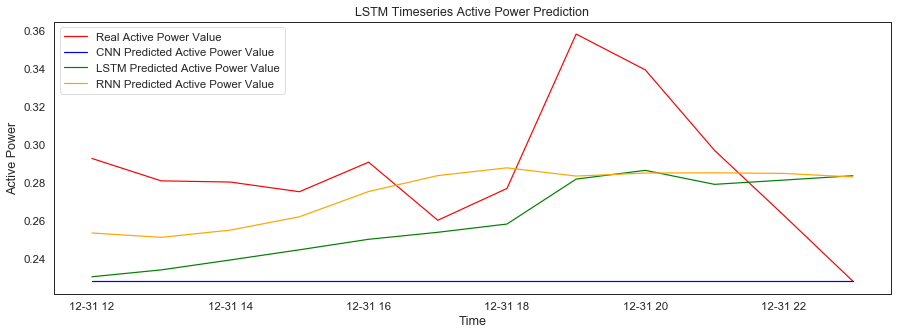

In [64]:
plt.figure(figsize=(15,5))
plt.plot(test_data.Active_Power[-300:], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['CNN_Predictions'][-300:], color = 'blue', label = 'CNN Predicted Active Power Value')
plt.plot(test_data['LSTM_predictions'][-300:], color = 'Green', label = 'LSTM Predicted Active Power Value')
plt.plot(test_data['RNN_Predictions'][-300:], color = 'Orange', label = 'RNN Predicted Active Power Value')
plt.title('LSTM Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()